In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="dark")
plt.rcParams.update({'font.size': 8})
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [2]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20 , offset=0):
    data = []
    min_size = np.inf
    for i,path in enumerate(glob.glob(env_path + 'seed*/')):
        try: 
            data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
#             print(data_set)
            data_set = np.stack(data_set)
#             print(data_set[-1])
            if data_set[-1,0] < min_size:
                min_size = data_set[-1,0]
            data.append(data_set)
            has_mode_insert_data = False
        except:
            pass
    x_samples = np.linspace(0, min_size, N)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0] 
#         _y = pull_max(data_set[:,1])
        _y = data_set[:,1] + offset

        interp_data.append(np.interp(x_samples, _x, _y))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}
    
    return data_log

def plot_data(ax, log, label):
#     print(len(log['data']))
    ax.plot(log['x'], log['mean'], label=label)
#     ax.fill_between(log['x'], 
#                     log['min'], log['max'],
#                     alpha=0.2)
    ax.fill_between(log['x'], 
                    log['-std'], log['+std'],
                    alpha=0.2)

def plot_mig_data(ax,raw_mig_data,interp=False,N=10):
    x = raw_mig_data[0][:,0]
    if interp: 
        _x = x
        x = np.linspace(x[0], x[-1], N)
        data = np.empty([N,0])
        for y in raw_mig_data: 
            interp_data = np.array([np.interp(x,_x,_y) for _y in y[:,1:].T])
            data = np.hstack([data,interp_data.T])
    else: 
        data = np.empty([10,0])
        for y in raw_mig_data: 
            data = np.hstack([data,y[:,1:]])
    print(data.shape)
    mig_mean= np.mean(data, axis=1)
    mig_min= np.min(data, axis=1)
    mig_max= np.max(data, axis=1)
    mig_std = np.std(data, axis=1)
    ax.plot(x,mig_mean,color='#2f466dff')
    ax.fill_between(x, 
#                     mig_min, mig_max,
                    mig_mean-mig_std, mig_mean+mig_std,
                    color='#2f466dff',
                    alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.set_xlim([0,x[-1]])

# mode insertion gradient

`mig.sh` reruns the checkpoints for each hybrid deterministic simulation. `mig_hlt.py` runs each checkpoint for each seed 10x. The averaged results and standard deviation are shown below. In this plot, the 'timesteps' are really checkpoints saved at those checkpoints (but re-run for an entire simulation duration i.e. 1000 steps for HopperEnv). So the standard deviation is the average of 100 datapoints (10 runs * 10 seeds). 

InvertedPendulumRoboschoolEnv (10, 10, 11)
(10, 100)
AcrobotEnv (10, 10, 6)
(10, 50)
HopperEnv (10, 10, 11)
(10, 100)
HalfCheetahEnv (10, 10, 11)
(10, 100)


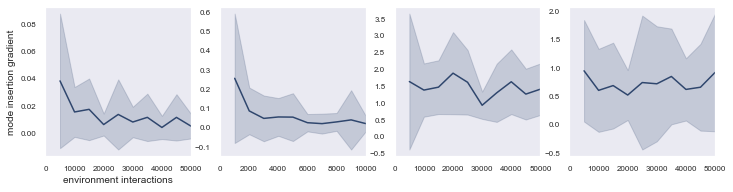

In [7]:
envs = ['InvertedPendulumRoboschoolEnv','AcrobotEnv','HopperEnv','HalfCheetahEnv']

fig, axs = plt.subplots(1, len(envs), figsize=(len(envs)*3,2.75))

for i, env in enumerate(envs):
    got_data = False
    try: 
        data_path = '../data/hlt_deter/{}/mig_log.pkl'.format(env)
        raw_mig_data = pickle.load(open(data_path, 'rb'))
        got_data = True                
    except: 
        pass
    if got_data: 
        print(env,np.array(raw_mig_data).shape)
        plot_mig_data(axs[i],raw_mig_data,interp=False)
#         axs[i].set_title(envs[i])
axs[0].set_ylabel('mode insertion gradient',fontsize=10)
axs[0].set_xlabel('environment interactions',fontsize=10)

plt.savefig('acrobot_mig.pdf', bbox_inches='tight')


# benchmark results
loads the rewards log for each simulation. the plots below the averages for each environment

hlt_deter
mpc_deter
sac__
hlt_stoch
mpc_stoch
sac__
-1084.9262244670679
-1017.6387658869531
-152.5169407345539
-706.2948555915364


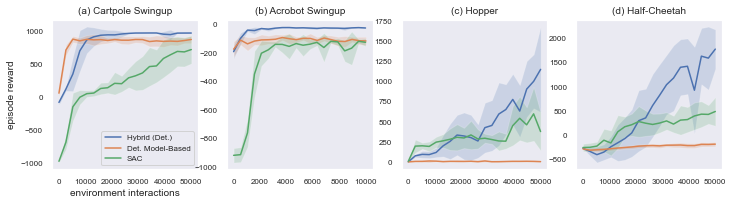

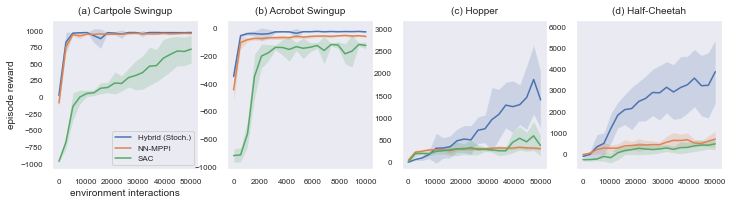

In [17]:
envs = ['InvertedPendulumRoboschoolEnv','AcrobotEnv','HopperEnv', 'HalfCheetahEnv'] 
max_frames = [50000,50000,50000]
ylim = [1163,60,3200,6321]

file_names = ['acrobot_deter.pdf',
              'acrobot_stoch.pdf']

methods_stoch = ['hlt_stoch','mpc_stoch','sac__']
methods_deter = ['hlt_deter','mpc_deter','sac__']
plot_legend_stoch = ['Hybrid (Stoch.)','NN-MPPI','SAC']
plot_legend_deter = ['Hybrid (Det.)','Det. Model-Based','SAC']
plot_titles = ['(a) Cartpole Swingup','(b) Acrobot Swingup', '(c) Hopper', '(d) Half-Cheetah']

for methods, plot_legend, save_name in zip([methods_deter,methods_stoch],
                                           [plot_legend_deter,plot_legend_stoch],
                                           file_names):
    fig, axs = plt.subplots(1, len(envs), figsize=(len(envs)*3,2.75))
    path_dir = '../data/'
    for method,lgd in zip(methods,plot_legend):
        for i, env in enumerate(envs):
            try:
                data_path = path_dir + '{}/{}/'.format(method, env)
                data = process_data(data_path)
                plot_data(axs[i], data, lgd)
                axs[i].set_title(plot_titles[i], fontsize=10)
#                 axs[i].set_xlabel('time steps', fontsize=10)
                axs[i].tick_params(axis='both', which='major', labelsize=8)
                if i == 0: 
                    print(method)
            except: 
                pass
    axs[0].set_ylabel('episode reward', fontsize=10)
    axs[0].legend(fontsize=8)
    axs[0].set_xlabel('environment interactions', fontsize=10)
    if methods == methods_stoch:
        for i in range(4): 
            [ymin,_] = axs[i].get_ylim()
            print(ymin)
            axs[i].set_ylim([ymin,ylim[i]])
    plt.savefig(save_name, bbox_inches='tight')
    
# testing
# try: 
#     data_path = path_dir + '{}/{}/'.format('sac__', 'HalfCheetahEnv_frameskip5')
#     data = process_data(data_path)
#     plot_data(axs[2], data,'test')
# except: 
#     pass

# alternate pendulum envs

PendulumEnv (10, 10, 6)
(10, 50)
AcrobotEnv (10, 10, 6)
(10, 50)
PendubotEnv (10, 10, 6)
(10, 50)


Text(0.5, 0, 'environment interactions')

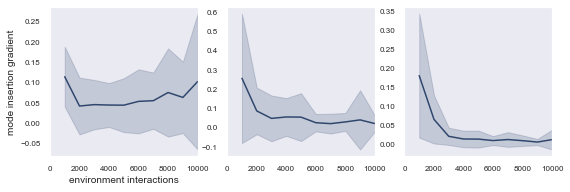

In [82]:
envs = ['PendulumEnv','AcrobotEnv','PendubotEnv'] 

fig, axs = plt.subplots(1, 3, figsize=(9,2.75))

for i, env in enumerate(envs):
    got_data = False
    try: 
        data_path = '../data/hlt_deter/{}/mig_log.pkl'.format(env)
        raw_mig_data = pickle.load(open(data_path, 'rb'))
        got_data = True                
    except: 
        pass
    if got_data: 
        print(env,np.array(raw_mig_data).shape)
        plot_mig_data(axs[i],raw_mig_data,interp=False)
#         axs[i].set_title(envs[i])
axs[0].set_ylabel('mode insertion gradient',fontsize=10)
axs[0].set_xlabel('environment interactions',fontsize=10)

# plt.savefig('bullet-mig.pdf', bbox_inches='tight')

hlt_deter
mpc_deter
sac__
hlt_stoch
mpc_stoch
sac__


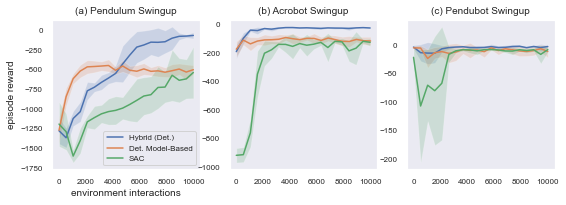

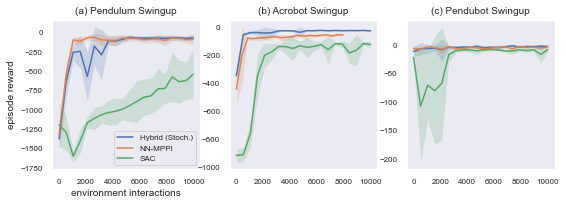

In [61]:
# alternate pendulum envs
envs = ['PendulumEnv','AcrobotEnv','PendubotEnv'] 
file_names = ['bullet-deter.pdf',
              'bullet-stoch.pdf']
plot_titles = ['(a) Pendulum Swingup', '(b) Acrobot Swingup', '(c) Pendubot Swingup']

methods_stoch = ['hlt_stoch','mpc_stoch','sac__']
methods_deter = ['hlt_deter','mpc_deter','sac__']
plot_legend_stoch = ['Hybrid (Stoch.)','NN-MPPI','SAC']
plot_legend_deter = ['Hybrid (Det.)','Det. Model-Based','SAC']

for methods, plot_legend, save_name in zip([methods_deter,methods_stoch],
                                           [plot_legend_deter,plot_legend_stoch],
                                           file_names):
    fig, axs = plt.subplots(1, 3, figsize=(9,2.75))
    path_dir = '../data/'
    for method,lgd in zip(methods,plot_legend):
        for i, env in enumerate(envs):
            try:
                data_path = path_dir + '{}/{}/'.format(method, env)
                data = process_data(data_path)
                plot_data(axs[i], data, lgd)
                axs[i].set_title(plot_titles[i], fontsize=10)
#                 axs[i].set_xlabel('time steps', fontsize=10)
                axs[i].tick_params(axis='both', which='major', labelsize=8)
                if i == 0: 
                    print(method)
            except: 
                pass
    axs[0].set_ylabel('episode reward', fontsize=10)
    axs[0].legend(fontsize=8)
    axs[0].set_xlabel('environment interactions', fontsize=10)
#     plt.show()
#     plt.savefig(save_name, bbox_inches='tight')